GMM CLUSTERING

In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

from jcopml.plot import plot_missing_value 

from scipy.stats import multivariate_normal

Preprocessing 

In [72]:
data = pd.read_csv("GMM_DATASET.csv")
data.head()

,Atribut_01,Atribut_02
0,67.062924,176.086355
1,68.804094,178.388669
2,60.930863,170.284496
3,59.733843,168.691992
4,65.431230,173.763679


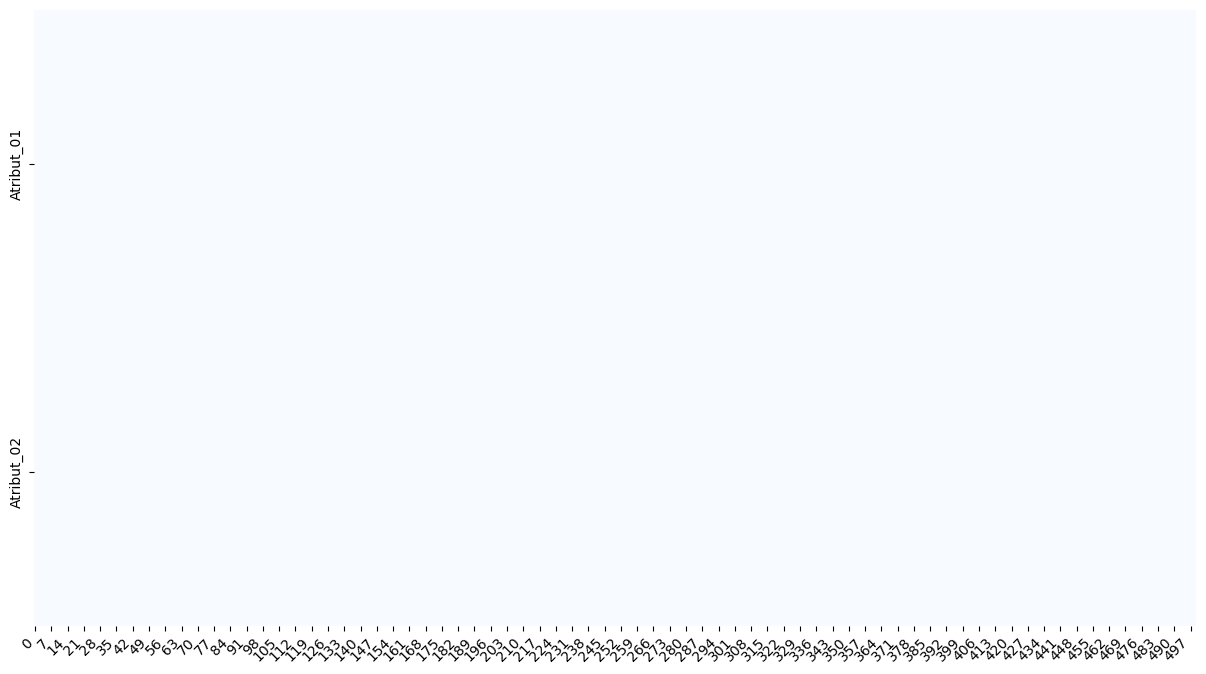

In [73]:
plot_missing_value(data)

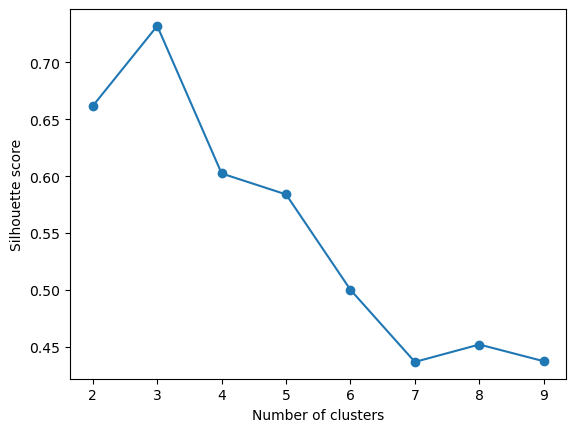

In [74]:
data = data[["Atribut_01", "Atribut_02"]]
silhouette_scores = []
for k in range(2,10):
    kmeans = KMeans(n_clusters=k)
    labels = kmeans.fit_predict(data)
    silhouette_scores.append(silhouette_score(data, labels))

plt.plot(range(2,10), silhouette_scores, marker="o")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score")
plt.show()

In [75]:
n_clusters = 3

INITIALIAZE MEANS, COVARIANCE, AND MIXING COEFFICIENT BASED ON K-MEANS PARAMETERS

In [76]:
# kmeans
kmeans = KMeans(n_clusters, random_state=0)
kmeans.fit(data[["Atribut_01", "Atribut_02"]])
mu= kmeans.cluster_centers_

print("Pusat klaster (mu):")
print(mu)

Pusat klaster (mu):
[[ 67.48040873 175.86017523]
 [ 53.60029808 162.76478198]
 [ 61.91101547 169.61922731]]


In [77]:
# matriks kovariansi
sigma = [np.cov(data[["Atribut_01", "Atribut_02"]][kmeans.labels_ == j].T) for j in range(n_clusters)]

print("Matriks kovariansi (sigma) dari data:")
print(sigma)

Matriks kovariansi (sigma) dari data:
[array([[1.30922477, 1.07638074],
       [1.07638074, 1.59487755]]), array([[1.25916073, 0.96444516],
       [0.96444516, 1.03652679]]), array([[2.95512591, 0.41617677],
       [0.41617677, 1.21083003]])]


In [78]:
# phi mixing coefficient
phi = (1 + np.sqrt(5)) / 2 

phis = []
for cov_matrix in sigma:
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    phi_cluster = eigenvalues[0] / eigenvalues[1] 
    phis.append(phi_cluster)

print("Nilai Phi untuk setiap klaster:")
print(phis)

Nilai Phi untuk setiap klaster:
[0.14430856169364134, 11.970300396576613, 2.7308582481908124]


In [79]:
pi = [1/n_clusters] * n_clusters

log_likelihood = 0

for i in range(len(data)):
    likelihood = 0
    for j in range(n_clusters):
        likelihood += pi[j] * multivariate_normal.pdf(data.iloc[i][["Atribut_01", "Atribut_02"]], mean=mu[j], cov=sigma[j])
    log_likelihood += np.log(likelihood)

print("Log-Likelihood:", log_likelihood)

Log-Likelihood: -2037.7908307920743


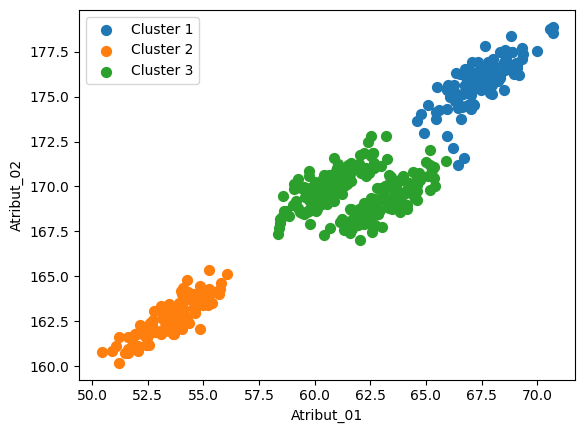

In [80]:
X = data[["Atribut_01", "Atribut_02"]]

fig, ax = plt.subplots()

for i in range(n_clusters):
    cluster_data = X[kmeans.labels_ == i]
    ax.scatter(cluster_data["Atribut_01"], cluster_data["Atribut_02"], label=f'Cluster {i+1}', s=50)

ax.set_xlabel("Atribut_01")
ax.set_ylabel("Atribut_02")
ax.legend()

plt.show()

E-STEP : EVALUATE THE RESPONSIBILITIES USING CURRENT PARAMETER VALUES AND CHECK CONVERGENCE VALUES

In [81]:
# Number of iterations
max_iter = 100
tolerance = 1e-6  

for iteration in range(max_iter):
    # Expectation step
    # Calculate the responsibilities
    responsibilities = np.zeros((len(data), n_clusters))
    for i in range(len(data)):
        for j in range(n_clusters):
            responsibilities[i, j] = pi[j] * multivariate_normal.pdf(
                data.iloc[i][["Atribut_01", "Atribut_02"]], mean=mu[j], cov=sigma[j]
            )

    # Normalize the responsibilities
    responsibilities /= responsibilities.sum(axis=1, keepdims=True)

    # Update parameters
    Nk = responsibilities.sum(axis=0)
    pi = Nk / len(data)
    for j in range(n_clusters):
        mu[j] = (responsibilities[:, j, None] * data[["Atribut_01", "Atribut_02"]]).sum(axis=0) / Nk[j]
        sigma[j] = np.cov(data[["Atribut_01", "Atribut_02"]].T, aweights=responsibilities[:, j])

    # Compute log-likelihood
    log_likelihood_new = 0
    for i in range(len(data)):
        likelihood = np.sum(pi[k] * multivariate_normal.pdf(data.iloc[i][["Atribut_01", "Atribut_02"]], mean=mu[k], cov=sigma[k]) for k in range(n_clusters))
        log_likelihood_new += np.log(likelihood)

    print(f"Iteration {iteration + 1}, Log-Likelihood: {log_likelihood_new}")

    # Check for convergence
    if np.abs(log_likelihood_new - log_likelihood) < tolerance:
        print("Converged.")
        break

    log_likelihood = log_likelihood_new

C:\Users\yasa\AppData\Local\Temp\ipykernel_46408\4249056124.py:28: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  likelihood = np.sum(pi[k] * multivariate_normal.pdf(data.iloc[i][["Atribut_01", "Atribut_02"]], mean=mu[k], cov=sigma[k]) for k in range(n_clusters))
C:\Users\yasa\AppData\Local\Temp\ipykernel_46408\4249056124.py:28: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  likelihood = np.sum(pi[k] * multivariate_normal.pdf(data.iloc[i][["Atribut_01", "Atribut_02"]], mean=mu[k], cov=sigma[k]) for k in range(n_clusters))
C:\Users\yasa\AppData\Local\Temp\ipykernel_46408\4249056124.py:28: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(gener

Iteration 1, Log-Likelihood: -2001.5789149949776


C:\Users\yasa\AppData\Local\Temp\ipykernel_46408\4249056124.py:28: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  likelihood = np.sum(pi[k] * multivariate_normal.pdf(data.iloc[i][["Atribut_01", "Atribut_02"]], mean=mu[k], cov=sigma[k]) for k in range(n_clusters))
C:\Users\yasa\AppData\Local\Temp\ipykernel_46408\4249056124.py:28: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  likelihood = np.sum(pi[k] * multivariate_normal.pdf(data.iloc[i][["Atribut_01", "Atribut_02"]], mean=mu[k], cov=sigma[k]) for k in range(n_clusters))
C:\Users\yasa\AppData\Local\Temp\ipykernel_46408\4249056124.py:28: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(gener

Iteration 2, Log-Likelihood: -2000.6420440005832


C:\Users\yasa\AppData\Local\Temp\ipykernel_46408\4249056124.py:28: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  likelihood = np.sum(pi[k] * multivariate_normal.pdf(data.iloc[i][["Atribut_01", "Atribut_02"]], mean=mu[k], cov=sigma[k]) for k in range(n_clusters))
C:\Users\yasa\AppData\Local\Temp\ipykernel_46408\4249056124.py:28: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  likelihood = np.sum(pi[k] * multivariate_normal.pdf(data.iloc[i][["Atribut_01", "Atribut_02"]], mean=mu[k], cov=sigma[k]) for k in range(n_clusters))
C:\Users\yasa\AppData\Local\Temp\ipykernel_46408\4249056124.py:28: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(gener

Iteration 3, Log-Likelihood: -2000.5737021931711


C:\Users\yasa\AppData\Local\Temp\ipykernel_46408\4249056124.py:28: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  likelihood = np.sum(pi[k] * multivariate_normal.pdf(data.iloc[i][["Atribut_01", "Atribut_02"]], mean=mu[k], cov=sigma[k]) for k in range(n_clusters))
C:\Users\yasa\AppData\Local\Temp\ipykernel_46408\4249056124.py:28: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  likelihood = np.sum(pi[k] * multivariate_normal.pdf(data.iloc[i][["Atribut_01", "Atribut_02"]], mean=mu[k], cov=sigma[k]) for k in range(n_clusters))
C:\Users\yasa\AppData\Local\Temp\ipykernel_46408\4249056124.py:28: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(gener

Iteration 4, Log-Likelihood: -2000.5666801356106


C:\Users\yasa\AppData\Local\Temp\ipykernel_46408\4249056124.py:28: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  likelihood = np.sum(pi[k] * multivariate_normal.pdf(data.iloc[i][["Atribut_01", "Atribut_02"]], mean=mu[k], cov=sigma[k]) for k in range(n_clusters))
C:\Users\yasa\AppData\Local\Temp\ipykernel_46408\4249056124.py:28: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  likelihood = np.sum(pi[k] * multivariate_normal.pdf(data.iloc[i][["Atribut_01", "Atribut_02"]], mean=mu[k], cov=sigma[k]) for k in range(n_clusters))
C:\Users\yasa\AppData\Local\Temp\ipykernel_46408\4249056124.py:28: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(gener

Iteration 5, Log-Likelihood: -2000.565671983071


C:\Users\yasa\AppData\Local\Temp\ipykernel_46408\4249056124.py:28: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  likelihood = np.sum(pi[k] * multivariate_normal.pdf(data.iloc[i][["Atribut_01", "Atribut_02"]], mean=mu[k], cov=sigma[k]) for k in range(n_clusters))
C:\Users\yasa\AppData\Local\Temp\ipykernel_46408\4249056124.py:28: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  likelihood = np.sum(pi[k] * multivariate_normal.pdf(data.iloc[i][["Atribut_01", "Atribut_02"]], mean=mu[k], cov=sigma[k]) for k in range(n_clusters))
C:\Users\yasa\AppData\Local\Temp\ipykernel_46408\4249056124.py:28: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(gener

Iteration 6, Log-Likelihood: -2000.5654653986385


C:\Users\yasa\AppData\Local\Temp\ipykernel_46408\4249056124.py:28: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  likelihood = np.sum(pi[k] * multivariate_normal.pdf(data.iloc[i][["Atribut_01", "Atribut_02"]], mean=mu[k], cov=sigma[k]) for k in range(n_clusters))
C:\Users\yasa\AppData\Local\Temp\ipykernel_46408\4249056124.py:28: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  likelihood = np.sum(pi[k] * multivariate_normal.pdf(data.iloc[i][["Atribut_01", "Atribut_02"]], mean=mu[k], cov=sigma[k]) for k in range(n_clusters))
C:\Users\yasa\AppData\Local\Temp\ipykernel_46408\4249056124.py:28: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(gener

Iteration 7, Log-Likelihood: -2000.5654132165573


C:\Users\yasa\AppData\Local\Temp\ipykernel_46408\4249056124.py:28: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  likelihood = np.sum(pi[k] * multivariate_normal.pdf(data.iloc[i][["Atribut_01", "Atribut_02"]], mean=mu[k], cov=sigma[k]) for k in range(n_clusters))
C:\Users\yasa\AppData\Local\Temp\ipykernel_46408\4249056124.py:28: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  likelihood = np.sum(pi[k] * multivariate_normal.pdf(data.iloc[i][["Atribut_01", "Atribut_02"]], mean=mu[k], cov=sigma[k]) for k in range(n_clusters))
C:\Users\yasa\AppData\Local\Temp\ipykernel_46408\4249056124.py:28: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(gener

Iteration 8, Log-Likelihood: -2000.5653989397879


C:\Users\yasa\AppData\Local\Temp\ipykernel_46408\4249056124.py:28: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  likelihood = np.sum(pi[k] * multivariate_normal.pdf(data.iloc[i][["Atribut_01", "Atribut_02"]], mean=mu[k], cov=sigma[k]) for k in range(n_clusters))
C:\Users\yasa\AppData\Local\Temp\ipykernel_46408\4249056124.py:28: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  likelihood = np.sum(pi[k] * multivariate_normal.pdf(data.iloc[i][["Atribut_01", "Atribut_02"]], mean=mu[k], cov=sigma[k]) for k in range(n_clusters))
C:\Users\yasa\AppData\Local\Temp\ipykernel_46408\4249056124.py:28: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(gener

Iteration 9, Log-Likelihood: -2000.5653949350178


C:\Users\yasa\AppData\Local\Temp\ipykernel_46408\4249056124.py:28: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  likelihood = np.sum(pi[k] * multivariate_normal.pdf(data.iloc[i][["Atribut_01", "Atribut_02"]], mean=mu[k], cov=sigma[k]) for k in range(n_clusters))
C:\Users\yasa\AppData\Local\Temp\ipykernel_46408\4249056124.py:28: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  likelihood = np.sum(pi[k] * multivariate_normal.pdf(data.iloc[i][["Atribut_01", "Atribut_02"]], mean=mu[k], cov=sigma[k]) for k in range(n_clusters))
C:\Users\yasa\AppData\Local\Temp\ipykernel_46408\4249056124.py:28: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(gener

Iteration 10, Log-Likelihood: -2000.5653938034368


C:\Users\yasa\AppData\Local\Temp\ipykernel_46408\4249056124.py:28: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  likelihood = np.sum(pi[k] * multivariate_normal.pdf(data.iloc[i][["Atribut_01", "Atribut_02"]], mean=mu[k], cov=sigma[k]) for k in range(n_clusters))
C:\Users\yasa\AppData\Local\Temp\ipykernel_46408\4249056124.py:28: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  likelihood = np.sum(pi[k] * multivariate_normal.pdf(data.iloc[i][["Atribut_01", "Atribut_02"]], mean=mu[k], cov=sigma[k]) for k in range(n_clusters))
C:\Users\yasa\AppData\Local\Temp\ipykernel_46408\4249056124.py:28: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(gener

Iteration 11, Log-Likelihood: -2000.565393483036
Converged.


C:\Users\yasa\AppData\Local\Temp\ipykernel_46408\4249056124.py:28: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  likelihood = np.sum(pi[k] * multivariate_normal.pdf(data.iloc[i][["Atribut_01", "Atribut_02"]], mean=mu[k], cov=sigma[k]) for k in range(n_clusters))
C:\Users\yasa\AppData\Local\Temp\ipykernel_46408\4249056124.py:28: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  likelihood = np.sum(pi[k] * multivariate_normal.pdf(data.iloc[i][["Atribut_01", "Atribut_02"]], mean=mu[k], cov=sigma[k]) for k in range(n_clusters))
C:\Users\yasa\AppData\Local\Temp\ipykernel_46408\4249056124.py:28: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(gener

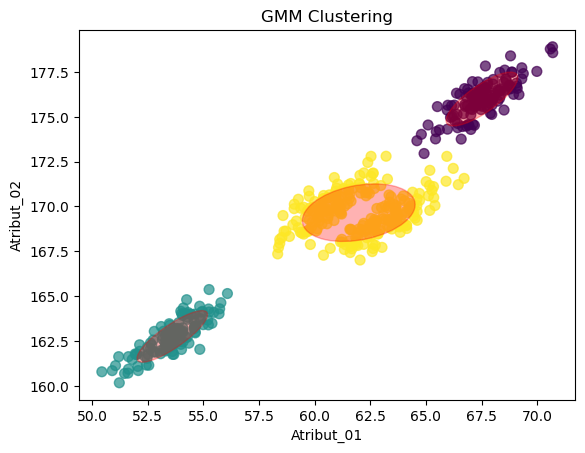

In [82]:
plt.scatter(data["Atribut_01"], data["Atribut_02"], c=responsibilities.argmax(axis=1), cmap='viridis', s=50, alpha=0.7)

# Plot ellipses for each cluster
for j in range(n_clusters):
    cov_matrix = sigma[j]
    mean_value = mu[j]
    v, w = np.linalg.eigh(cov_matrix)
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180.0 * angle / np.pi
    ell = plt.matplotlib.patches.Ellipse(mean_value, v[0], v[1], 180.0 + angle, color='red', alpha=0.3)
    ell.set_clip_box(plt.gca().bbox)
    ell.set_alpha(0.3)
    plt.gca().add_patch(ell)

plt.title('GMM Clustering')
plt.xlabel('Atribut_01')
plt.ylabel('Atribut_02')
plt.show()

GMM python library from sckitlearn

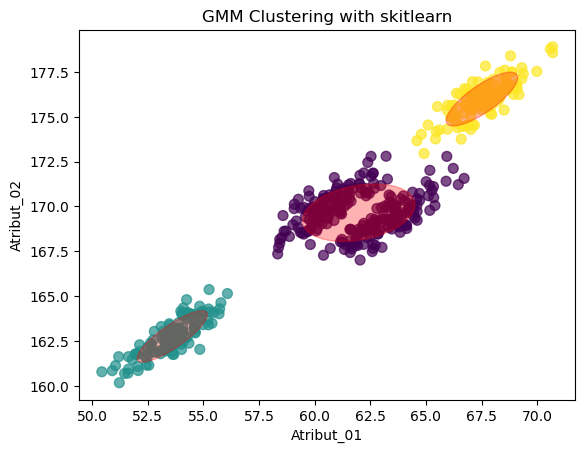

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

# Fit a Gaussian Mixture Model
gmm = GaussianMixture(n_components=n_clusters)
gmm.fit(data[["Atribut_01", "Atribut_02"]])

# Predict cluster labels
labels = gmm.predict(data[["Atribut_01", "Atribut_02"]])

# Plot the data points with cluster colors
plt.scatter(data["Atribut_01"], data["Atribut_02"], c=labels, cmap='viridis', s=50, alpha=0.7)

# Plot ellipses for each cluster
for j in range(n_clusters):
    cov_matrix = gmm.covariances_[j][:2, :2]
    mean_value = gmm.means_[j][:2]
    v, w = np.linalg.eigh(cov_matrix)
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    u = w[0] / np.linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180.0 * angle / np.pi
    ell = plt.matplotlib.patches.Ellipse(mean_value, v[0], v[1], 180.0 + angle, color='red', alpha=0.3)
    ell.set_clip_box(plt.gca().bbox)
    ell.set_alpha(0.3)
    plt.gca().add_patch(ell)

plt.title('GMM Clustering with skitlearn')
plt.xlabel('Atribut_01')
plt.ylabel('Atribut_02')
plt.show()